# Decison Support System
### Deciding Factors
- Longevity: time since review
- Length of title and text: count the number of words
- Helpfulness of a review: ratio of “helpful votes” to “total votes”
- Readership: total number of votes of a review
- Select products wtih atleast 100 reviews, eliminated the reviews that had less than 4 votes
- Polarity = positive sentiment + negative sentiment
- Sentiment = positive sentiment - negative sentiment - 2:

In [5]:
import pandas as pd
import numpy as np
import gzip 
import json
import shutil
import time
import math
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression

In [6]:
def getSentimentsAndLengthFromFile(nameOfFile):
    df=pd.DataFrame()
    file = open(nameOfFile, encoding = "utf8")
    count = 0
    column_names = []
    for line in file:
        count=count+1
        if count is 1:
            column_names = line.split('\t')
            df=pd.DataFrame(columns = column_names)
        temp_line = line.rstrip().split('\t')
        df = df.append(pd.Series(temp_line ,index = column_names), ignore_index = True)
    file.close()
    return df

def unzipJson(filename, saveas):
    "both arguments are strings"
    with gzip.open(filename, 'rb') as f_in:
        with open(saveas, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
def getDataFromJsonFile(filename, noOfRev):
    count = 0
    df = pd.DataFrame()
    with open(filename, 'r') as f:
        for line in f:
            if count == noOfRev:
                break
            count = count + 1
            if count%500==0:
                print(count)
            data = json.loads(line)
            dictionary=json.loads(line)
            dictionary["helpful"] = str(dictionary["helpful"][0])+":"+str(dictionary["helpful"][1])
            df = df.append(pd.DataFrame(dictionary,index = [count]), sort = False)
    return df

def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''
    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

#### Description of the below cell
- unzip the json.gz file 
- get a dataFrame consisting of 35000 reviews
- store this dataFrame in a csv file
- now this csv file is converted to a txt file that is then
    analysed using the sentistrength software, resulting is a
    txt file having analysed result

In [7]:
# unzipJson("reviews_Electronics_5.json.gz","reviews_Electronics_5.json")
# df = getDataFromJsonFile("reviews_Electronics_5.json",35000)
# df.to_csv("dataset_electronic.csv")


#### Description of the below cell
- dataset_analysed.txt contains all the analysed data that is converted to a dataFrame
- dataFrame is stored in a csv file for faster access next time


In [ ]:
# data = getSentimentsAndLengthFromFile("dataset_analysed.txt")

In [ ]:
# data = data.drop(0,0)
# data.to_csv("dataset.csv")

In [ ]:
# data['polarityText'] = data['reviewTextPositive'] + data['reviewTextNegative']
# data['polaritySummary'] = data['summaryPositive'] + data['summaryNegative\n']
# data['sentimentText'] = data['reviewTextPositive'] - data['reviewTextNegative']-2
# data['sentimentSummary'] = data['summaryPositive'] - data['summaryNegative\n'] - 2
# data['summaryLength'] = data['summary'].str.split().str.len()
# data['reviewTextLength'] = data['reviewText'].str.split().str.len()
# data['readership'] = data['helpful'].str.split(':').str[1]
# data['longetivity'] = time.time() - data['unixReviewTime']
# del data['no']

In [ ]:
# data.to_csv("dataset.csv")

In [8]:
# read the dataset
data = pd.read_csv('dataset.csv')
data['helpful_votes'] = data['helpful'].str.split(':').str[0]
data['helpful_votes'] = data.helpful_votes.astype(float)
data['longetivity'] = data['longetivity']//86400


In [9]:
# Select products wtih atleast 100 reviews, eliminated the reviews that had less than 4 votes
tempDf = data.groupby('asin').size().rename("countOfReviews").reset_index()
data = data.merge(tempDf)
data = data[data['countOfReviews'] >= 100]
data = data.loc[data['readership'] >= 4]

In [10]:
table1Df = pd.DataFrame(columns=['range', 'median', 'mean', 'SD'], 
                        index = ['Rating', 'Longetivity', 'Total Votes', 'Helpful votes', 'Title sentiment',
                                 'Title polarity', 'Review sentiment', 'Review polarity', 'Title length', 'Review length'])

table1Df.loc['Rating'] = pd.Series({
    'range' : str(data['overall'].min())+'-'+str(data['overall'].max()),
    'median' : data['overall'].median(),
    'mean' : data['overall'].mean(),
    'SD' : data['overall'].std()
})
table1Df.loc['Longetivity'] = pd.Series({
    'range' : str(data['longetivity'].min())+'-'+str(data['longetivity'].max()),
    'median' : data['longetivity'].median(),
    'mean' : data['longetivity'].mean(),
    'SD' : data['longetivity'].std()
})
table1Df.loc['Total Votes'] = pd.Series({
    'range' : str(data['readership'].min())+'-'+str(data['readership'].max()),
    'median' : data['readership'].median(),
    'mean' : data['readership'].mean(),
    'SD' : data['readership'].std()
})
table1Df.loc['Helpful votes'] = pd.Series({
    'range' : str(data['helpful_votes'].min())+'-'+str(data['helpful_votes'].max()),
    'median' : data['helpful_votes'].median(),
    'mean' : data['helpful_votes'].mean(),
    'SD' : data['helpful_votes'].std()
})
table1Df.loc['Title sentiment'] = pd.Series({
    'range' : str(data['sentimentSummary'].min())+'-'+str(data['sentimentSummary'].max()),
    'median' : data['sentimentSummary'].median(),
    'mean' : data['sentimentSummary'].mean(),
    'SD' : data['sentimentSummary'].std()
})
table1Df.loc['Title polarity'] = pd.Series({
    'range' : str(data['polaritySummary'].min())+'-'+str(data['polaritySummary'].max()),
    'median' : data['polaritySummary'].median(),
    'mean' : data['polaritySummary'].mean(),
    'SD' : data['polaritySummary'].std()
})
table1Df.loc['Review sentiment'] = pd.Series({
    'range' : str(data['sentimentText'].min())+'-'+str(data['sentimentText'].max()),
    'median' : data['sentimentText'].median(),
    'mean' : data['sentimentText'].mean(),
    'SD' : data['sentimentText'].std()
})
table1Df.loc['Review polarity'] = pd.Series({
    'range' : str(data['polarityText'].min())+'-'+str(data['polarityText'].max()),
    'median' : data['polarityText'].median(),
    'mean' : data['polarityText'].mean(),
    'SD' : data['polarityText'].std()
})
table1Df.loc['Title length'] = pd.Series({
    'range' : str(data['summaryLength'].min())+'-'+str(data['summaryLength'].max()),
    'median' : data['summaryLength'].median(),
    'mean' : data['summaryLength'].mean(),
    'SD' : data['summaryLength'].std()
})
table1Df.loc['Review length'] = pd.Series({
    'range' : str(data['reviewTextLength'].min())+'-'+str(data['reviewTextLength'].max()),
    'median' : data['reviewTextLength'].median(),
    'mean' : data['reviewTextLength'].mean(),
    'SD' : data['reviewTextLength'].std()
})


## Formula
- log(Total Votes) = B0 + B1 * Title_Sentiment + B2 * TITLE_POSTIVE + B3 * Title_length + B4 * Title_Sentiment * TITLE_POSTIVE + B5 * log(Review_Length) + B6 * log(Longevity)

In [11]:
data
table1Df


,range,median,mean,SD
Rating,1.0-5.0,4,3.75608,1.50318
Longetivity,1710.0-6887.0,4082,4033.06,1169.66
Total Votes,4-1591,7,24.1913,69.5943
Helpful votes,0.0-1556.0,6,20.6897,66.8541
Title sentiment,0-5,1,1.11111,1.0663
Title polarity,-4-4,0,0.578567,1.24204
Review sentiment,0-8,3,3.17094,1.44084
Review polarity,-3-4,0,0.350427,1.15912
Title length,1-23,5,5.1716,2.85392
Review length,9.0-2079.0,121,176.77,178.095


In [12]:
readerData= pd.DataFrame()
readerData['Title_Sentiment'] = data['sentimentSummary']
readerData['TITLE_POSITIVE'] = data['polaritySummary']
readerData.loc[readerData['TITLE_POSITIVE'] > 0,'temp'] = 1
readerData.loc[readerData['TITLE_POSITIVE'] <= 0,'temp'] = 0
readerData['TITLE_POSITIVE'] = readerData['temp']
del readerData['temp']
readerData['Title_Length'] = data['summaryLength']
readerData['B4_mul'] = readerData['Title_Sentiment'] * readerData['TITLE_POSITIVE']
readerData['B5_mul'] = np.log(data['reviewTextLength'])
readerData['B6_mul'] = np.log(data['longetivity'])
readerData['TITLE_POSITIVE'] = data['summaryPositive']
logTotalVotes = np.log10(data['readership'])

In [13]:
reg = LinearRegression().fit(readerData, logTotalVotes)

In [15]:
# reg.coef_
readerData['logTotalVotes']=logTotalVotes
readerData.head()
list(data)
reg.coef_

array([-0.01047036, -0.07413579,  0.0048672 ,  0.04432912,  0.09628507,
        0.42113113])

/mnt/WorkSpace/05_Current/Decison-Support-System/venv/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


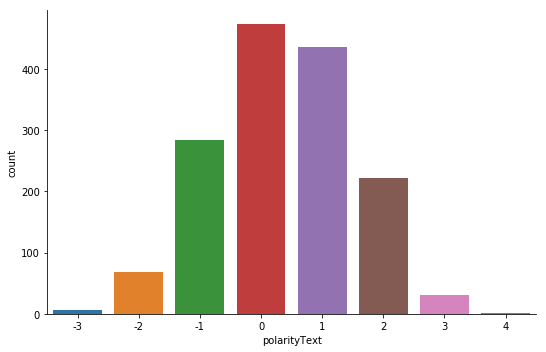

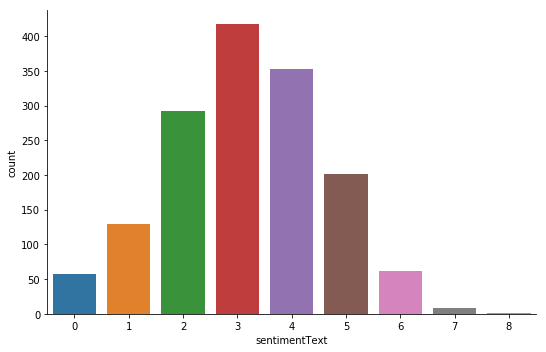

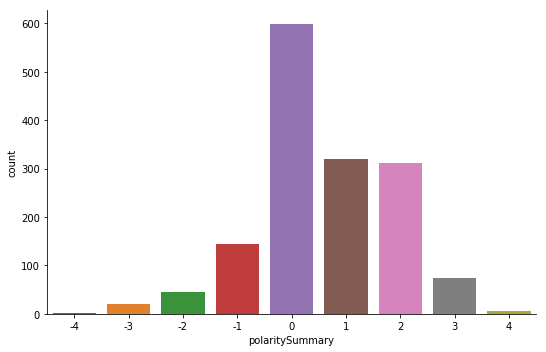

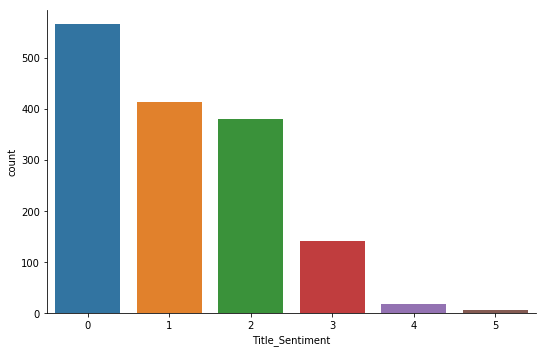

In [16]:
fml = 'logTotalVotes ~ Title_Sentiment + TITLE_POSITIVE + Title_Length + B4_mul + B5_mul + B6_mul'
g = sns.factorplot(x='sentimentText',data=data, kind='count', aspect=1.5)
g = sns.factorplot(x='polaritySummary',data=data, kind='count', aspect=1.5)
g = sns.factorplot(x='Title_Sentiment',data=readerData, kind='count', aspect=1.5)

In [ ]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=readerData, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(1000, tune=500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu, B6_mul, B5_mul, B4_mul, Title_Length, TITLE_POSITIVE, Title_Sentiment, Intercept]
Sampling 4 chains:   2%|▉                                                     | 103/6000 [17:32<57:23:40, 35.04s/draws]

In [26]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace, varnames=rvs)

NameError: name 'trace' is not defined

In [ ]:
pm.summary()